<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/5_CodingDrillDown/Experiments/MNIST_With9kParams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Iteration

**Objective** : In previous [experiment](https://github.com/gkdivya/EVA/blob/main/4_ArchitecturalBasics/Experiments/MNIST_Exp2_WithTransitionBlock.ipynb) with **5690** parameters, we were able to achieve 98% accuracy. In this notebook, we will be using **Batch Normalization** and observe if it helps with the accuracy.

**Batch Normalization**:
Even though we normalize the input values with Image normalization transform, parameter values changes while training the network.

Batch Normalization is a technique to normalize the values getting passed within the network. 

Its normally applied to activations of a prior convolutional layer or on the inputs directly.

[torch.nn.BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) 

It helps with faster and smoother training process.


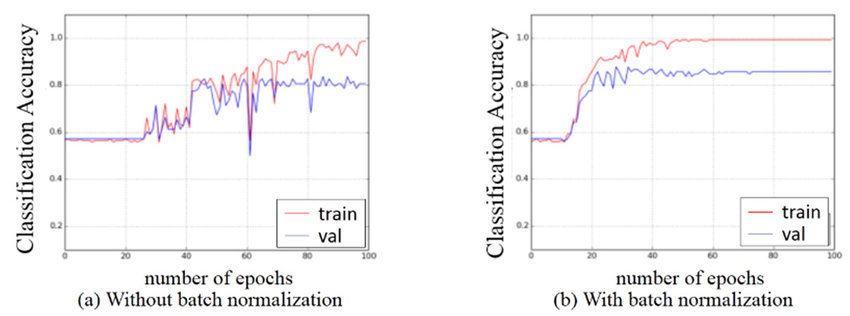


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR,OneCycleLR


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(0.1),

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.1),
        ) 

        #Transition Block
        self.trans1 = nn.Sequential(
            
            nn.MaxPool2d(2, 2), # output_size = 12
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False)
        ) # output_size = 24
        

        # CONVOLUTION BLOCK 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(10),
            nn.Dropout(0.1),

            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(0.1),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(0.1),

            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(0.1)

        ) 
        
        # OUTPUT BLOCK
        self.avgpool2d = nn.AvgPool2d(kernel_size=6)

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(32),
            nn.Dropout(0.1))

        self.conv4 = nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)


    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.avgpool2d(x)
        x = self.conv3(x)
        x = self.conv4(x)


        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 10, 10, 10]             720
             ReLU-12           [-1, 10, 10, 10]               0
      BatchNorm2d-13           [-1, 10, 10, 10]              20
          Dropout-14           [-1, 10,

In [ ]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        # transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                        # transforms.RandomResizedCrop(224),
                        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                        # transforms.RandomHorizontalFlip(),
                        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    epoch_loss=0
    correct = 0
    processed = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Epoch{epoch} : Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')


    train_loss = epoch_loss / len(train_loader.dataset)
    train_acc=100.*correct/len(train_loader.dataset)
    return train_loss,train_acc


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc=100. * correct / len(test_loader.dataset)
    return test_loss,test_acc

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_loss_values = []
test_loss_values = []
train_accuracy=[]
test_accuracy=[]

scheduler = OneCycleLR(optimizer, max_lr=0.01,epochs=15,steps_per_epoch=len(train_loader))

for epoch in range(1, 16):
    train_loss,train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss,test_acc = test(model, device, test_loader)

    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

    # scheduler.step()

Epoch1 : Loss=0.7421121001243591 Batch_id=468 Accuracy=58.28: 100%|██████████| 469/469 [00:30<00:00, 15.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.2486, Accuracy: 9420/10000 (94.20%)



Epoch2 : Loss=0.3000975549221039 Batch_id=468 Accuracy=90.49: 100%|██████████| 469/469 [00:30<00:00, 15.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0696, Accuracy: 9807/10000 (98.07%)



Epoch3 : Loss=0.08599983900785446 Batch_id=468 Accuracy=94.52: 100%|██████████| 469/469 [00:30<00:00, 15.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0479, Accuracy: 9851/10000 (98.51%)



Epoch4 : Loss=0.11003377288579941 Batch_id=468 Accuracy=95.94: 100%|██████████| 469/469 [00:30<00:00, 15.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0374, Accuracy: 9885/10000 (98.85%)



Epoch5 : Loss=0.12892906367778778 Batch_id=468 Accuracy=96.53: 100%|██████████| 469/469 [00:30<00:00, 15.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0394, Accuracy: 9874/10000 (98.74%)



Epoch6 : Loss=0.0734177753329277 Batch_id=468 Accuracy=96.88: 100%|██████████| 469/469 [00:30<00:00, 15.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0270, Accuracy: 9904/10000 (99.04%)



Epoch7 : Loss=0.05788233503699303 Batch_id=468 Accuracy=97.21: 100%|██████████| 469/469 [00:30<00:00, 15.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0266, Accuracy: 9917/10000 (99.17%)



Epoch8 : Loss=0.04186994209885597 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:30<00:00, 15.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0232, Accuracy: 9924/10000 (99.24%)



Epoch9 : Loss=0.023087814450263977 Batch_id=468 Accuracy=97.50: 100%|██████████| 469/469 [00:30<00:00, 15.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0204, Accuracy: 9932/10000 (99.32%)



Epoch10 : Loss=0.0354161374270916 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:31<00:00, 15.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0228, Accuracy: 9927/10000 (99.27%)



Epoch11 : Loss=0.11449640244245529 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:31<00:00, 14.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0217, Accuracy: 9937/10000 (99.37%)



Epoch12 : Loss=0.05072089657187462 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:30<00:00, 15.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0217, Accuracy: 9926/10000 (99.26%)



Epoch13 : Loss=0.08745807409286499 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:30<00:00, 15.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0195, Accuracy: 9936/10000 (99.36%)



Epoch14 : Loss=0.0639684796333313 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:30<00:00, 15.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.0182, Accuracy: 9942/10000 (99.42%)



Epoch15 : Loss=0.06960237771272659 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:31<00:00, 14.92it/s]


Test set: Average loss: 0.0179, Accuracy: 9941/10000 (99.41%)



## Incorrect Predictions

In [ ]:
def print_wrong_predictions(test_loader,model,device):
  wrong_images=[]
  wrong_label=[]
  correct_label=[]
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)        
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

      wrong_pred = (pred.eq(target.view_as(pred)) == False)
      wrong_images.append(data[wrong_pred])
      wrong_label.append(pred[wrong_pred])
      correct_label.append(target.view_as(pred)[wrong_pred])   

  return list(zip(torch.cat(wrong_images),torch.cat(wrong_label),torch.cat(correct_label)))

In [ ]:
wrong_predictions = print_wrong_predictions(test_loader,model,device)

In [ ]:
print(f'Total wrong predictions are {len(wrong_predictions)}')

Total wrong predictions are 59


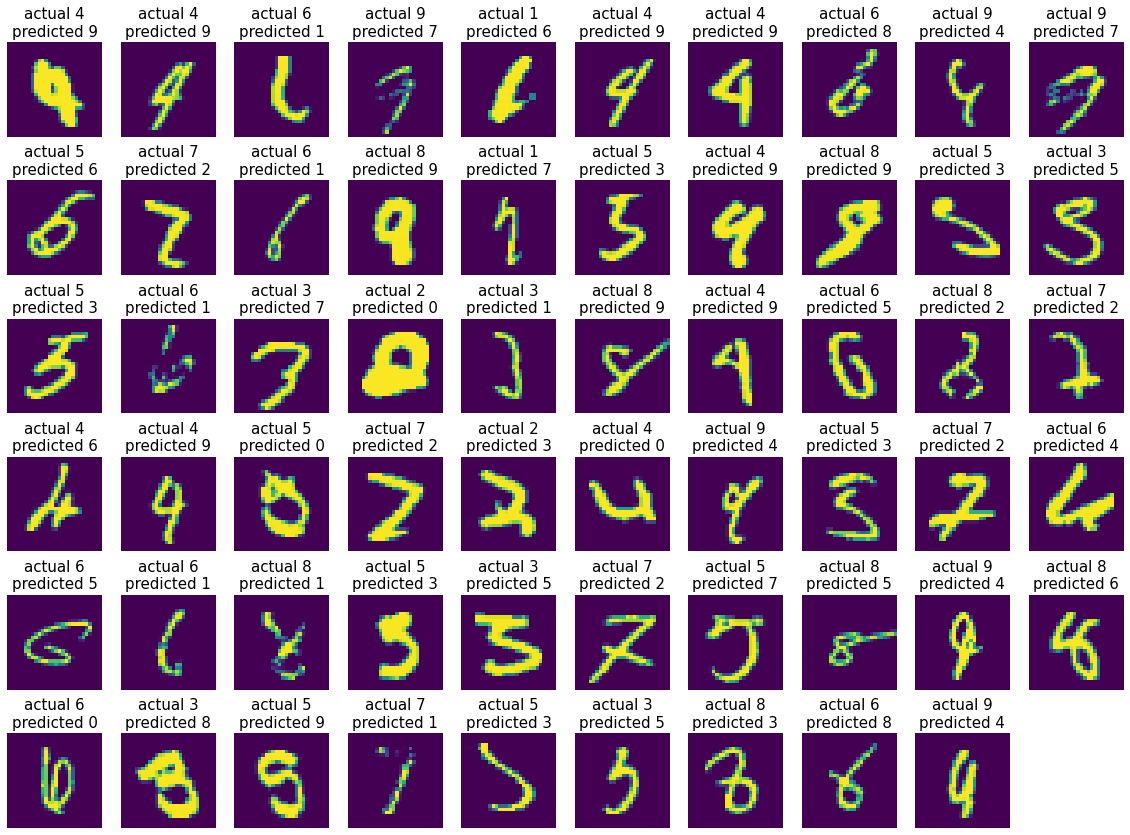

In [ ]:
fig = plt.figure(figsize=(20,25))
for i, (img, pred, correct) in enumerate(wrong_predictions):
    img, pred, target = img.cpu().numpy(), pred.cpu(), correct.cpu()
    ax = fig.add_subplot(10, 10, i+1)
    ax.axis('off')
    ax.set_title(f'actual {target.item()}\npredicted {pred.item()}',fontsize=15)
    ax.imshow(img.squeeze())
plt.show()